# Framing the Problem and the tools

This project has two goals:
- Going through the phases of a classical NLP project, making particular emphasis on particular NLP techniques like CountVectorization
- Implementing MLflow to shortlist promising models. Here a brief intro of MLflow and its components will be given. Focusing on "MLflow tracking" we will see why and when makes sense to use it for personal projects.

*data source: https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech*

# Importing the libraries and data

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient


In [92]:
# Load the data
tweets_df = pd.read_csv(r"..\data\twitter.csv")


In [93]:
tweets_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [94]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [95]:
tweets_df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [96]:
tweets_df.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


Taking a first look at the data we can see that we do not have any instance empty. That was clear since Twitter does not allow to publish empty tweets. We have over 30.000 tweets to play with and we can also see that the "id" column is not going to bring anything so we can just drop it.

In [97]:
tweets_df.drop(columns=['id'],inplace=True)

In [98]:
tweets_df.columns

Index(['label', 'tweet'], dtype='object')

We can see that the column was successfully dropped

# Exploratory Data Analysis

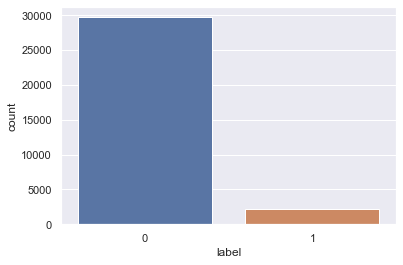

In [99]:
sns.set_theme()
ax = sns.countplot(x="label", data=tweets_df)
#looking at the graph we see that we have an unbalanced dataset because we have many with the label 0 (positive tweets) but very few with label 1 (negative tweets)

Seeing the proportion of positive tweets (zeros) with respect to negative tweets (ones) we can draw two conclusions:
- The dataset comes from particularly happy people
- We have a very skewed dataset. Since there are so very few negative tweets, compared to the positive ones, we can already tell that accuracy is not going to be a good measure of performance. When comparing our binary classifiers we should rather try to compare other metrics like f1-score.

In [100]:
# Let's get the length of the messages
tweets_df['length'] = tweets_df['tweet'].apply(len)

In [101]:
tweets_df.head()

,label,tweet,length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39


<AxesSubplot:ylabel='Frequency'>

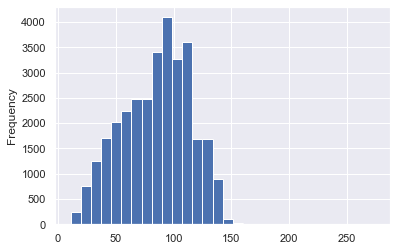

In [102]:
tweets_df['length'].plot(bins=30, kind='hist')

The distribution of the lengths is rather normal being the mean 85.

In [103]:
tweets_df.describe()

,label,length
count,31962.000000,31962.000000
mean,0.070146,84.739628
std,0.255397,29.455749
min,0.000000,11.000000
25%,0.000000,63.000000
50%,0.000000,88.000000
75%,0.000000,108.000000
max,1.000000,274.000000


In [104]:
tweets_df['length'].mean().round() #  message with the average length

85.0

In [105]:
positive_tweets = tweets_df[tweets_df['label']==0]

In [106]:
positive_tweets.head()

,label,tweet,length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39


In [107]:
negative_tweets = tweets_df[tweets_df['label']==1]

In [108]:
negative_tweets.head()

,label,tweet,length
13,1,@user #cnn calls #michigan middle school 'buil...,74
14,1,no comment! in #australia #opkillingbay #se...,101
17,1,retweet if you agree!,22
23,1,@user @user lumpy says i am a . prove it lumpy.,47
34,1,it's unbelievable that in the 21st century we'...,104


## Wordcloud

In [109]:
sentences = tweets_df['tweet'].tolist()

In [110]:
sentences[1:5]

["@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
 '  bihday your majesty',
 '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
 ' factsguide: society now    #motivation']

In [111]:
sentences_together = " ".join(sentences)

To install WordCloud check for the version of wordcloud available for the version of python and operating system you are using using this link: https://pypi.org/project/wordcloud/#history and install it from the terminal with this line "pip install wordcloud -version-compatible-operatingsystem"

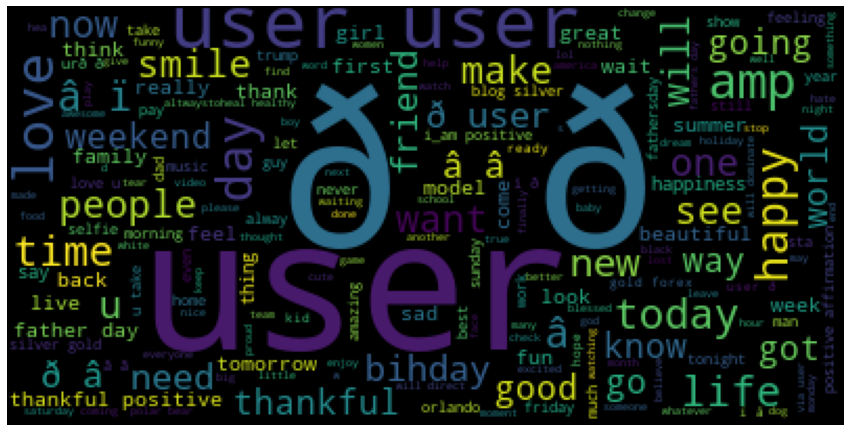

In [112]:
from wordcloud import WordCloud
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(sentences_together))
plt.axis("off")
plt.show()

We can see that most common words are indeed common words like "user". There seems to be also weird characters appearing rather often. We will get rid of this in a later section.

In [113]:
# now we do the same with the negative sentences
negative_sentences = negative_tweets["tweet"].tolist()

In [114]:
negative_sentences[1:5]

['no comment!  in #australia   #opkillingbay #seashepherd #helpcovedolphins #thecove  #helpcovedolphins',
 'retweet if you agree! ',
 '@user @user lumpy says i am a . prove it lumpy.',
 "it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia "]

In [115]:
negative_sentences_on_one_string = " ".join(negative_sentences)

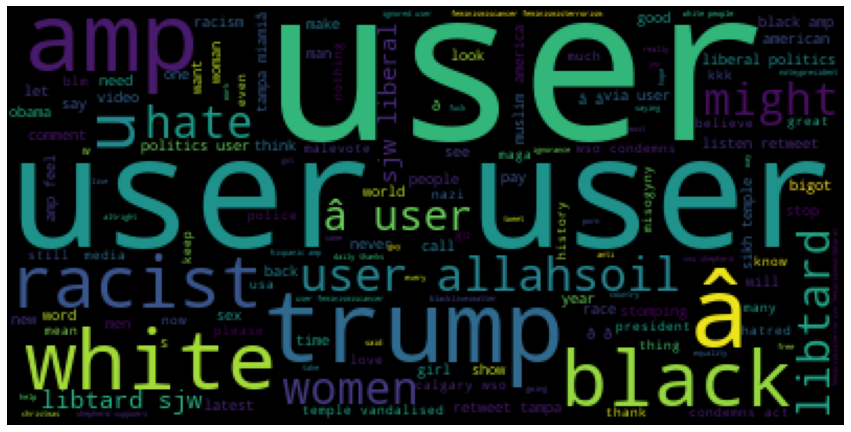

In [116]:
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(negative_sentences_on_one_string))
plt.axis("off")
plt.show()

When ploting the WordCloud for negative tweets we can see that some of these tweets are likely racists or sexist.

# Data Cleaning

Let's first focus on removing punctuation marks and weird characters.

In [117]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [118]:
test_with_punctuation = 'This is a random sentence ! /: ;<=>? with random characters ./: ;<=>? @[\ \] '

In [119]:
test_without_punctuation = [ char for char in test_with_punctuation if char not in string.punctuation]

In [120]:
print(test_without_punctuation)

['T', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 'r', 'a', 'n', 'd', 'o', 'm', ' ', 's', 'e', 'n', 't', 'e', 'n', 'c', 'e', ' ', ' ', ' ', ' ', 'w', 'i', 't', 'h', ' ', 'r', 'a', 'n', 'd', 'o', 'm', ' ', 'c', 'h', 'a', 'r', 'a', 'c', 't', 'e', 'r', 's', ' ', ' ', ' ', ' ', ' ']


In [121]:
# Join the characters again to form the string.
test_without_punctuation_together = "".join((test_without_punctuation))

In [122]:
print(test_without_punctuation_together)

This is a random sentence    with random characters     


Alternative method to remove punctuation marks:


In [123]:
import re
my_punct = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '.',
           '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_',
           '`', '{', '|', '}', '~', '»', '«', '“', '”']

punct_pattern = re.compile("[" + re.escape("".join(my_punct)) + "]")
re.sub(punct_pattern, "", test_with_punctuation) # the "-" symbol should remain


'This is a random sentence    with random characters     '


## Remove stopwords

Here we are basically going to make the wordcloud look better by removing common words from the english language, also known as "stopwords".

In [124]:
import nltk # Natural Language tool kit 

nltk.download('stopwords') #punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [125]:
from nltk.corpus import stopwords
stopwords.words('english')[1:10]

['me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [126]:
test_without_punctuation_together_clean = [word for word in test_without_punctuation_together.split() if word not in stopwords.words('english')] # Only important (no so common) words are left

In [127]:
test_without_punctuation_together

'This is a random sentence    with random characters     '

In [128]:
test_without_punctuation_together_clean

['This', 'random', 'sentence', 'random', 'characters']

Create a function/pipeline to remove punctuations and stopwords

In [129]:
test_sentence = 'This is a test sentende to remove !) punctuation marks and stopwords'

In [130]:
import nltk
import string
from nltk.corpus import stopwords

nltk.download('stopwords')
default_stopwords = stopwords.words('english')
def clean_text(Text):
    def remove_punctuactions(Text):
        import string
        Text_punc_removed = [ char for char in Text if char not in string.punctuation]
        Text_punc_removed_join = "".join((Text_punc_removed))
        return Text_punc_removed_join

    def remove_stopwords(Text):
        Text_punc_removed_join_clean = [word for word in Text.split() if word not in default_stopwords]
        return Text_punc_removed_join_clean

    Text = remove_punctuactions(Text)
    Text = remove_stopwords(Text)

    return Text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
clean_text(test_sentence)

['This', 'test', 'sentende', 'remove', 'punctuation', 'marks', 'stopwords']

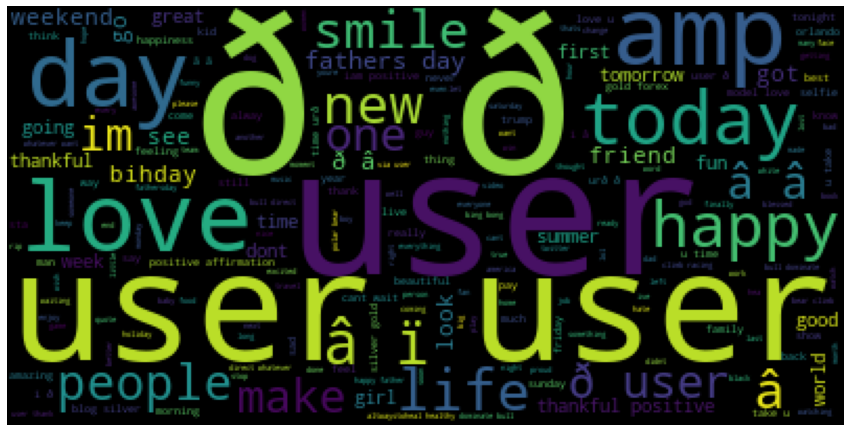

In [132]:
clean_sentences = clean_text(sentences_together)
clean_sentences_together = " ".join((clean_sentences))
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(clean_sentences_together))
plt.axis("off")
plt.show()

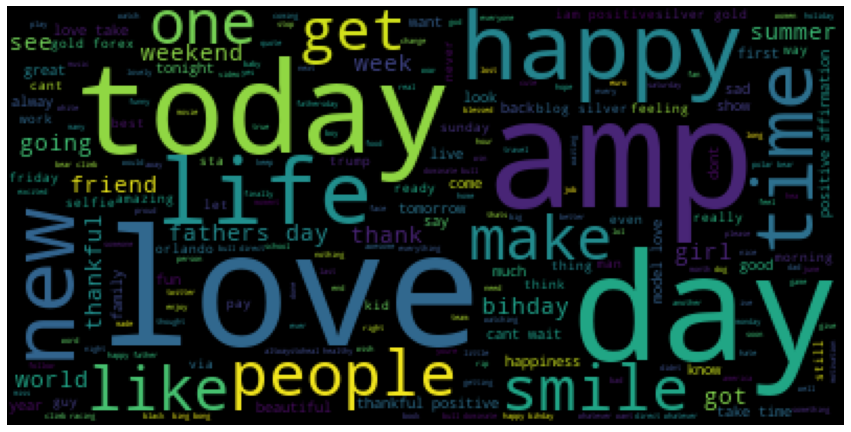

In [133]:
temp_sentences_together= clean_sentences_together
import re
 # Converting the whole text to lowercase
temp_sentences_together = temp_sentences_together.lower()
 # Removing the twitter usernames from tweet string
temp_sentences_together=re.sub(r'@\w+', ' ', temp_sentences_together)
 # Removing the URLS from the tweet string
temp_sentences_together=re.sub(r'http\S+', ' ', temp_sentences_together)
 # Deleting everything which is not characters
temp_sentences_together = re.sub(r'[^a-z A-Z]', ' ',temp_sentences_together)
 # Deleting any word which is less than 3-characters mostly those are stopwords
temp_sentences_together= re.sub(r'\b\w{1,2}\b', '', temp_sentences_together)
 # Stripping extra spaces in the text
clean_sentences_together= re.sub(r' +', ' ', temp_sentences_together)
stop_words = ["user"] + list(default_stopwords)
wordcloud = WordCloud(stopwords = stop_words).generate(clean_sentences_together)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Tokenization: performing count vectorization

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
example_sentences = ['This is a random sentence.','I hope you are enjoying reading this.','Insert text here.']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(example_sentences)

In [135]:
print(vectorizer.get_feature_names())

['are', 'enjoying', 'here', 'hope', 'insert', 'is', 'random', 'reading', 'sentence', 'text', 'this', 'you']


c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [136]:
print(X.toarray())

[[0 0 0 0 0 1 1 0 1 0 1 0]
 [1 1 0 1 0 0 0 1 0 0 1 1]
 [0 0 1 0 1 0 0 0 0 1 0 0]]


Now we extend the previous function/pipeline perform as well count vectorization. For that we use the parameter "analyzer" from sklearn's CountVectorizer. Here if a callable is passed it is used to extract the sequence of features out of the raw, unprocessed input.

In [137]:
# This function is similar to the previous one and removes punctuation and stopwords

def message_cleaning(message):
    message_punc_removed = [char for char in message if char not in string.punctuation]
    message_punc_removed_join = ''.join(message_punc_removed)
    message_punc_removed_join_clean = [word for word in message_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return message_punc_removed_join_clean

from sklearn.feature_extraction.text import CountVectorizer
# Define the cleaning pipeline we defined earlier
vectorizer = CountVectorizer(analyzer = message_cleaning)

tweets_countvectorizer = CountVectorizer(analyzer = message_cleaning, dtype = 'uint8').fit_transform(tweets_df['tweet']).toarray()

In [138]:
tweets_countvectorizer.shape


(31962, 47386)

In [139]:
tweets = pd.DataFrame(tweets_countvectorizer)
X = tweets
y = tweets_df['label']

# MLflow



## Why MLflow?

Like with any tool you first have to ask yourself if you even need it in the first place.
MLflow has many uses and possible implementations but here we will be just focusing on the following use case:
- I am in a prototype phase and want to shortlist promising models. For that I want to train many quick models from different categories using standard parameters and want to be able to compare easily their performance.

Here is also practical to analyze the significant variables within each algorithm and also analyze the errors that the models make. Most likely a few iterations are needed here. For that "MLflow Tracking" is optimal.

## MLflow components

MLflow allows you to manage the whole ML lifecycle, from experimenting with initial models to deployment, improving at the same time reproducibility and providing you with a central model registry. You can see their great docu on their website ("https://mlflow.org/") so here I will just explain briefly their four main components, focusing on the tracking module for our case:
- MLflow Projects: here we have a similar concept to Docker. We encapsulate the dependencies so it can run in any machine. A project in MLflow consists on 2 parts: the MLproject where you define the path of the environment, ... and a conda.yaml file where you would define all the dependencies. As with Docker goal is to have projects reproduced in any platform.
- MLflow Models: the concept of models in MLflow is analog to their projects. You can make models using whatever ML Framework you want (sklearn, Tensorflow, XGBoost, ...). You can load these models using different "flavours" like with a python function or with tensorflow. The goal here is to deploy any machine learning model working with possible different environments.
- Model Registry: here is where you can deploy your model to production. Here you have as well different tools for CI/CD and you can manage everything from within a central repository-
- MLflow Tracking: with the tracking component MLflow basically enables you to keep a diary of your experiments. This is useful if you are working on a team and you have to compare different models with different parameters. However, this is also very useful if you are working alone, deploying in your local machine, and you are at the stage of prototyping and want to compare easily different models to later fine tune a couple of them


Note: It is worth mentioning that MLflow does not focus on the registry of datasets. If you are familiar with "DVC" for the version control of your datasets you can have that integrate it in your MLflow workflow. If you are new to data version control you might wanna use "Delta Lake" since MLflow integrates it in its workflow directly.

## Start MLflow UI


If you want to run MLflow’s Tracking UI from the Notebook, you have to write *!mlflow ui* instead of *mlflow ui*.
Notice that you will get a syntax error running *mlflow ui* because it is not a valid Python syntax. If you run *!mlflow ui* from the Notebook you can still view the Tracking UI at http://localhost:5000 (http://127.0.0.1:5000). In this case, however, you will not be able to run any other cell, since the current cell keeps running. For that you must interrupt manually after a couple of seconds running this cell and continue with the next ones.

In [140]:
!mlflow ui
# Interrupt the execution of this cell manually and go to http://127.0.0.1:5000

^C


 ## Initialize MLflow


When opening the UI in your browser you can see the tab "Experiments" where you can organize runs into experiments, which group together runs for a specific task.

MLflow runs can be recorded to local files, to a database, or remotely to a tracking server.
If not specified otherwise MLflow logs runs locally to files in an mlruns directory wherever you ran your program. If you set a different Tracking Uri you can have it also deployed on a server on the cloud.

MLflow tracking server has two components for storage:
- Backend store: where the experiments are stored as well as run metadata, params, metrics, and tags for runs. The backend stores can be either file store or database-backed store.
- Artifact store: an example of an artifact could be your model or other large data files like images. If you want to deploy online some places where this can be hosted are Amazon S3 or Azure Blob Storage or Google Cloud Storage.

In [148]:
experiment_name = "NLP_mlflow_experiments"
artifact_repository = './mlflow-run'
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
client = MlflowClient() # Initialize client
# Get the experiment id if it already exists and if not create it
try:
    experiment_id = client.create_experiment(experiment_name, artifact_location=artifact_repository)
except:
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

## Prepare data for model training


So the models can train faster and since the goal of this section is to train quick some models and see how they compare with MLflow I reduce significantly the size of the dataset.

In [149]:
from sklearn.model_selection import train_test_split
X, y = X[1:300], y[1:300]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.6, random_state=42)


## Define MLFlow model experimentation function


A couple of notes on the following lines of code:
- When setting the tags you can add a note for the experiment which is very practical when using MLflow Tracking as a personal diary of experiments.
- Notice how similar the commands are to sklearn, this is done, so it is very easy to migrate any experiment you have done previously.
- The "autolog" will be performed when you call "fit" or "fit_predict" or "fit_transform" and it will automatically record parameters and key training metrics like precision score, f1-score,... without you having to explicitly track them.

In [150]:
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

def model_experimentation(classifier, model_name, run_name):
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
        run_id = run.info.run_uuid
        MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "Project to test different machine learning models for Twitter Sentiment Analysis with MLflow")
        mlflow.sklearn.autolog() # Logged information like Parameters and Training metrics (like precission score, f1 score, ...)

        tags = {"Application": "Twitter Sentiment Analysis",
                "release.version": "1.0.0"}
        mlflow.set_tags(tags)

        clf = classifier
        clf.fit(X_train, y_train)

        valid_prediction = clf.predict_proba(X_valid)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_valid, valid_prediction)
        roc_auc = auc(fpr, tpr)
        mlflow.log_metrics({"Validation_AUC": roc_auc})
        ConfusionMatrixDisplay.from_estimator(clf, X_valid, y_valid,
                              display_labels=['Placed', 'Not Placed'],
                              cmap='magma')
        plt.title('Confusion Matrix')
        plt.axis("off")
        filename = f'./images/{model_name}_validation_confusion_matrix.png'
        plt.savefig(filename)
        mlflow.log_artifact(filename)

To test the capabilities of MLflow Tracking we will compare Naive Bayes, SVM, KNN and a Logistic Regression model.

## Naive Bayes Training and evaluation + MLFlow for model tracking


2022/04/11 13:43:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


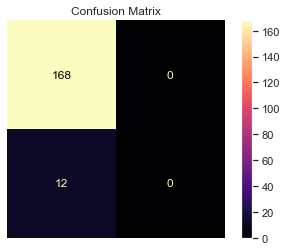

2022/04/11 13:44:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/04/11 13:44:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`."
2022/04/11 13:44:39 WARNING mlflow.utils.autol

KeyboardInterrupt: 

In [151]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
model_name = 'NB'
run_name = 'NaiveBayes_model'
model_experimentation(classifier, model_name, run_name)

## SVM Training and evaluation + MLFlow for model tracking

With SVM you have to watch out. Since we will be calculating the ROC Curve we need to call the function with the probability estimates obtained from calling "predict_proba". So we need to ensure that all classifiers can estimate class probabilities. Unfortunately this is not the case for the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method).

c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/04/11 13:44:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/04/11 13:44:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\utils\deprecation.p

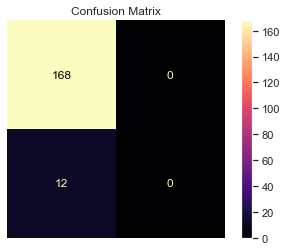

In [ ]:
from sklearn.svm import SVC

classifier = SVC(probability=True)
model_name = 'SVC'
run_name = 'SVC_model'
model_experimentation(classifier, model_name, run_name)

## KNN Training and evaluation + MLFlow for model tracking

c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/04/11 13:44:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/04/11 13:44:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\utils\deprecation.p

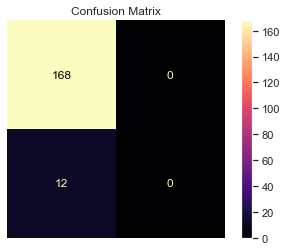

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
model_name = 'KNN'
run_name = 'KNN_model'
model_experimentation(classifier, model_name, run_name)

## Logistic Regression Classifier Training and evaluation + MLFlow for model tracking

2022/04/11 13:44:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/04/11 13:44:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\users\jaime\pycharmprojects\nlp_twitter_mlflow\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`."
2022/04/11 13:44:30 WARNING mlflow.utils.autol

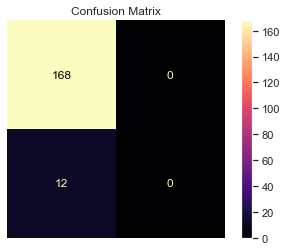

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
model_name = 'LogReg'
run_name = 'LR_model'
model_experimentation(classifier, model_name, run_name)

Now that  we have selected a couple of models we can proceed with fine-tuning. This is out of the scope of this post but notice that here we would like to use as much data as possible so definately the original data from the dataset and if possible even more.